# Simple Neural Network Regression with Keras and JAX

#### [John Stachurski](https://johnstachurski.net/) Nov 2024

This lecture shows how to implement one-dimensional nonlinear regression
using a neural network.

We will use the popular deep learning library [Keras](https://keras.io/), which
provides a simple and elegant interface to deep learning.

The emphasis in Keras is on providing an intuitive API, while the heavy lifting is
done by another library.

Currently the backend library can be Tensorflow, PyTorch, or JAX.

In this lecture we will use JAX.

The objective of this lecture is to provide a very simple introduction to deep
learning in a regression setting.

We begin with some standard imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's install Keras.

In [2]:
!pip install keras

Now we specify that the desired backend is JAX.

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'jax'

Next we import some tools from Keras.

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense

## Data

First let's write a function to generate some data.

The data has the form

$$
    y_i = f(x_i) + \epsilon_i,
    \qquad i=1, \ldots, n
$$

The map $f$ is specified inside the function and $\epsilon_i$ is an independent
draw from a fixed normal distribution.

Here's the function that creates vectors `x` and `y` according to the rule
above.

In [5]:
def generate_data(x_min=0, x_max=5, data_size=400):
    x = np.linspace(x_min, x_max, num=data_size)
    x = x.reshape(data_size, 1)
    ϵ = 0.2 * np.random.randn(*x.shape)
    y = x**0.5 + np.sin(x) + ϵ
    x, y = [z.astype('float32') for z in (x, y)]
    return x, y

Now we generate some data to train the model.

In [6]:
x, y = generate_data()

Here's a plot of the training data.

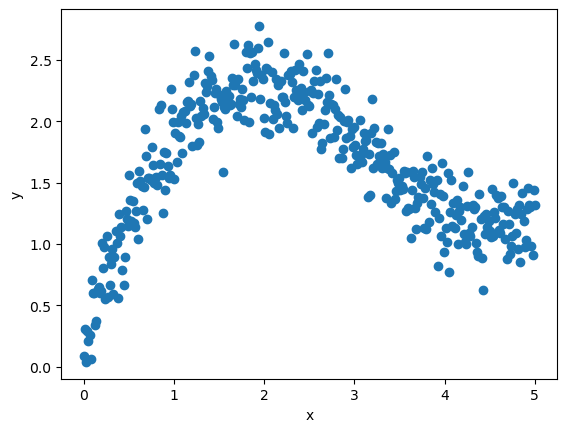

In [7]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

We'll also use data from the same process for cross-validation.

In [8]:
x_validate, y_validate = generate_data()

## Models

We supply functions to build two types of models.

The first implements linear regression.

This is achieved by constructing a neural network with just one layer, that maps
to a single dimension (since the prediction is real-valued).

The input `model` will be an instance of `keras.Sequential`, which is used to
group a stack of layers into a single prediction model.

In [9]:
def build_regression_model(model):
    model.add(Dense(units=1))
    model.compile(optimizer=keras.optimizers.SGD(), 
                  loss='mean_squared_error')
    return model

In the function above you can see that we use stochastic gradient descent to
train the model, and that the loss is mean squared error (MSE).

MSE is the standard loss function for ordinary least squares regression.

The second function creates a dense (i.e., fully connected) neural network with
3 hidden layers, where each hidden layer maps to a k-dimensional output space.

In [10]:
def build_nn_model(model, k=10, activation_function='tanh'):
    # Construct network
    model.add(Dense(units=k, activation=activation_function))
    model.add(Dense(units=k, activation=activation_function))
    model.add(Dense(units=k, activation=activation_function))
    model.add(Dense(1))
    # Embed training configurations
    model.compile(optimizer=keras.optimizers.SGD(), 
                  loss='mean_squared_error')
    return model

The following function will be used to plot the MSE of the model during the
training process.

Initially the MSE will be relatively high, but it should fall at each iteration,
as the parameters are adjusted to better fit the data.

In [11]:
def plot_loss_history(training_history, ax):
    ax.plot(training_history.epoch, 
            np.array(training_history.history['loss']), 
            label='training loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (Mean squared error)')
    ax.legend()

## Training

Now let's go ahead and train our  models.


### Linear regression

We'll start with linear regression.

First we create a `Model` instance using `Sequential()`.

In [12]:
model = Sequential()
regression_model = build_regression_model(model)

Now we train the model using the training data.

In [13]:
training_history = regression_model.fit(
    x, y, batch_size=x.shape[0], verbose=0,
    epochs=1500)

Let's have a look at the evolution of MSE as the model is trained.

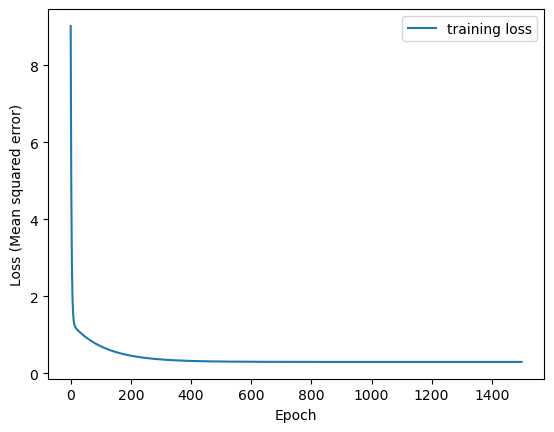

In [14]:
fig, ax = plt.subplots()
plot_loss_history(training_history, ax)
plt.show()

Let's print the final MSE on the cross-validation data.

In [15]:
print("Testing loss on the validation set.")
regression_model.evaluate(x_validate, y_validate, verbose=2)

Testing loss on the validation set.
13/13 - 0s - 9ms/step - loss: 0.2923


0.2923440933227539

Here's our output predictions on the cross-validation data.

In [16]:
y_predict = regression_model.predict(x_validate, verbose=2)

13/13 - 0s - 3ms/step


We use the following function to plot our predictions along with the data.

In [17]:
def plot_results(x, y, y_predict, ax):
    ax.scatter(x, y)
    ax.plot(x, y_predict, label="fitted model", color='black')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

Let's now call the function on the cross-validation data.

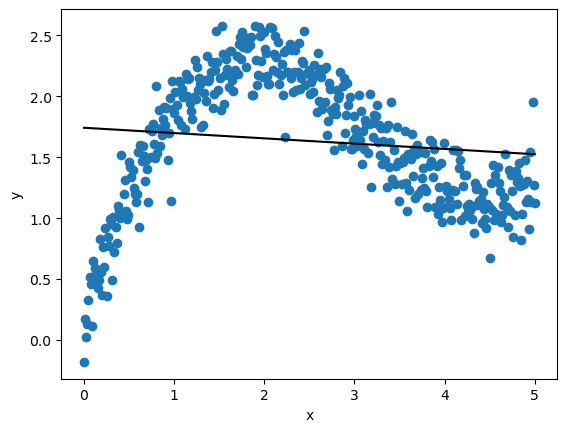

In [18]:
fig, ax = plt.subplots()
plot_results(x_validate, y_validate, y_predict, ax)
plt.show()

### Deep learning

Now let's switch to a neural network with multiple layers.

We implement the same steps as before.

In [19]:
model = Sequential()
nn_model = build_nn_model(model)

In [20]:
training_history = nn_model.fit(
    x, y, batch_size=x.shape[0], verbose=0,
    epochs=1500)

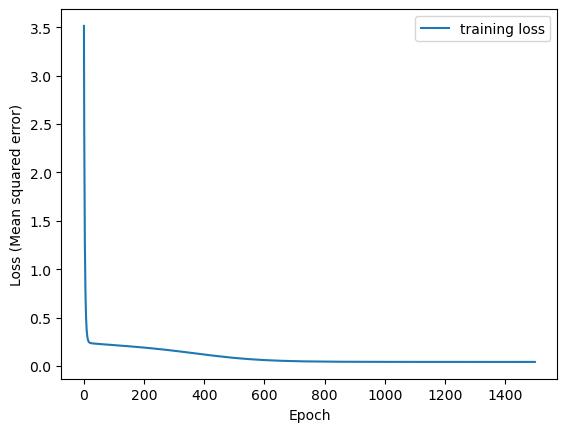

In [21]:
fig, ax = plt.subplots()
plot_loss_history(training_history, ax)
plt.show()

Here's the final MSE for the deep learning model.

In [22]:
print("Testing loss on the validation set.")
nn_model.evaluate(x_validate, y_validate, verbose=2)

Testing loss on the validation set.
13/13 - 0s - 32ms/step - loss: 0.0406


0.040648870170116425

You will notice that this loss is much lower than the one we achieved with
linear regression, suggesting a better fit.

To confirm this, let's look at the fitted function.

In [23]:
y_predict = nn_model.predict(x_validate, verbose=2)

13/13 - 0s - 14ms/step


In [24]:
def plot_results(x, y, y_predict, ax):
    ax.scatter(x, y)
    ax.plot(x, y_predict, label="fitted model", color='black')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

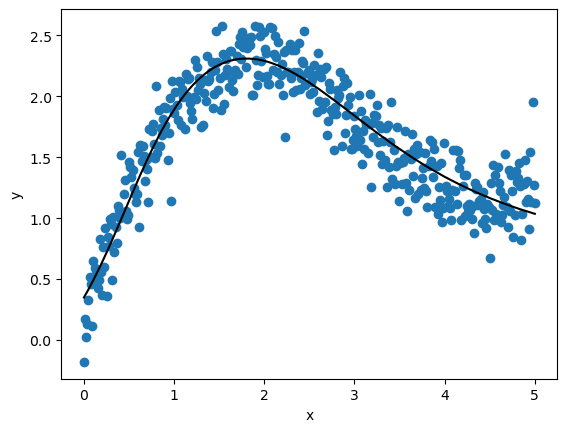

In [25]:
fig, ax = plt.subplots()
plot_results(x_validate, y_validate, y_predict, ax)
plt.show()